<a href="https://colab.research.google.com/github/marcelo-guimaraes/Data-Science/blob/master/market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objetivo
O objetivo deste produto é fornecer um serviço automatizado que recomenda leads para um usuário dado sua atual lista de clientes (Portfólio).

## Contextualização
Algumas empresas gostariam de saber quem são as demais empresas em um determinado mercado (população) que tem maior probabilidade se tornarem seus próximos clientes. Ou seja, a sua solução deve encontrar no mercado quem são os leads mais aderentes dado as características dos clientes presentes no portfólio do usuário.

Além disso, sua solução deve ser agnóstica ao usuário. Qualquer usuário com uma lista de clientes que queira explorar esse mercado pode extrair valor do serviço.

Para o desafio, deverão ser consideradas as seguintes bases:

Mercado: Base com informações sobre as empresas do Mercado a ser considerado.
Portfolio 1: Ids dos clientes da empresa 1
Portfolio 2: Ids dos clientes da empresa 2
Portfolio 3: Ids dos clientes da empresa 3


## Análise Exploratória

In [181]:
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 
import math

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA


import folium
from folium import plugins

import category_encoders as ce

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
df_market = pd.read_csv('/content/drive/My Drive/estaticos_market.csv', index_col=0, parse_dates=['dt_situacao'])
df1 = pd.read_csv('/content/drive/My Drive/portfolio1.csv', index_col=0)
df2 = pd.read_csv('/content/drive/My Drive/portfolio2.csv', index_col=0)
df3 = pd.read_csv('/content/drive/My Drive/portfolio3.csv', index_col=0)

In [129]:
df_mark = df_market.copy()
print("Shape: {} linhas e {} colunas".format(df_mark.shape[0],df_mark.shape[1]))
df_mark.head()

Shape: 462298 linhas e 181 colunas


,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,fl_optante_simples,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,vl_potenc_cons_oleo_gas,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,...,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,idade_ate_18,idade_de_19_a_23,idade_de_24_a_28,idade_de_29_a_33,idade_de_34_a_38,idade_de_39_a_43,idade_de_44_a_48,idade_de_49_a_53,idade_de_54_a_58,idade_acima_de_58,grau_instrucao_macro_analfabeto,grau_instrucao_macro_escolaridade_fundamental,grau_instrucao_macro_escolaridade_media,grau_instrucao_macro_escolaridade_superior,grau_instrucao_macro_desconhecido,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,False,False,2005-03-25,False,True,True,SIM,CONSTRUCAO DE EDIFICIOS,CONSTRUCAO,False,False,False,NaN,NaN,NaN,NaN,True,8.0,0.0,0.0,NaN,NaN,NaN,False,RN,VERDE,ACIMA DE 1 ANO,23.0,...,3132172.8,3132172.8,119.0,26.0,100.0,0.0,NaN,1.0,4.0,6.0,5.0,3.0,4.0,2.0,NaN,1.0,NaN,1.0,25.0,NaN,NaN,26.0,19.166667,0.0,0.0,119.0,145.0,13.309195,93.266667,-0.933333,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,False,True,False,2017-05-12,False,True,True,SIM,ALIMENTACAO,ALOJAMENTO E ALIMENTACAO,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,PI,CINZA,ATE 1 ANO,9.0,...,210000.0,210000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,False,False,True,False,2011-09-26,False,False,True,SIM,TRANSPORTE TERRESTRE,TRANSPORTE ARMAZENAGEM E CORREIO,False,False,False,NaN,NaN,NaN,NaN,True,NaN,0.0,0.0,NaN,NaN,NaN,True,AM,AMARELO,ACIMA DE 1 ANO,26.0,...,50000.0,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,False,False,False,False,2012-04-25,False,True,True,SIM,REPARACAO E MANUTENCAO DE EQUIPAMENTOS DE INFO...,OUTRAS ATIVIDADES DE SERVICOS,False,False,False,NaN,NaN,NaN,NaN,True,NaN,0.0,0.0,NaN,NaN,NaN,False,AM,AMARELO,ACIMA DE 1 ANO,26.0,...,210000.0,210000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,False,False,False,False,2015-08-17,False,True,True,SIM,SERVICOS DE ARQUITETURA E ENGENHARIA TESTES E ...,ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS,False,False,Fals

#### Tamanho dos arquivos:


In [130]:
df1 = df1[['id']]

port1 = df1.merge(df_mark, how = 'inner', on = 'id')
port2 = df2.merge(df_mark, how = 'inner', on = 'id')
port3 = df3.merge(df_mark, how = 'inner', on = 'id')

In [131]:
print('Dados do Mercado: {}'.format(df_mark.shape),
      '\nPortfolio 1: {}'.format(port1.shape),
      '\nPortfolio 2: {}'.format(port2.shape),
      '\nPortfolio 3: {}'.format(port3.shape))

Dados do Mercado: (462298, 181) 
Portfolio 1: (555, 181) 
Portfolio 2: (566, 181) 
Portfolio 3: (265, 181)


## Processamento e limpeza dos Dados


Excluir colunas que apresentam grande quantidade de Missing Values, Multicolinearidade e que apresentam alta cardinalidade ...

#### Primeiro excluo colunas que apresentam mais de 20% dos dados como faltantes


In [132]:
df_mark = df_mark[df_mark.columns[df_mark.isnull().mean() < 0.2]]
#df_mark.set_index('id', inplace = True)

In [133]:
print("Shape: {} linhas e {} colunas".format(df_mark.shape[0],df_mark.shape[1]))
df_mark.head()

Shape: 462298 linhas e 42 colunas


,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,fl_simples_irregular,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,False,False,2005-03-25,False,True,True,SIM,CONSTRUCAO DE EDIFICIOS,CONSTRUCAO,False,False,False,True,0.0,0.0,False,RN,VERDE,ACIMA DE 1 ANO,23.0,ALTA,False,LESTE POTIGUAR,NATAL,True,"DE R$ 1.500.000,01 A R$ 4.800.000,00","DE R$ 1.500.000,01 A R$ 4.800.000,00",3132172.8,3132172.8,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,False,True,False,2017-05-12,False,True,True,SIM,ALIMENTACAO,ALOJAMENTO E ALIMENTACAO,False,False,False,NaN,0.0,0.0,NaN,PI,CINZA,ATE 1 ANO,9.0,BAIXA,False,CENTRO NORTE PIAUIENSE,TERESINA,True,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,False,False,True,False,2011-09-26,False,False,True,SIM,TRANSPORTE TERRESTRE,TRANSPORTE ARMAZENAGEM E CORREIO,False,False,False,True,0.0,0.0,True,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,False,CENTRO AMAZONENSE,MANAUS,True,"ATE R$ 81.000,00","ATE R$ 81.000,00",50000.0,50000.0,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,False,False,False,False,2012-04-25,False,True,True,SIM,REPARACAO E MANUTENCAO DE EQUIPAMENTOS DE INFO...,OUTRAS ATIVIDADES DE SERVICOS,False,False,False,True,0.0,0.0,False,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,False,CENTRO AMAZONENSE,MANAUS,True,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,False,False,False,False,2015-08-17,False,True,True,SIM,SERVICOS DE ARQUITETURA E ENGENHARIA TESTES E ...,ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS,False,False,False,True,0.0,0.0,False,RN,VERDE,ACIMA DE 1 ANO,27.0,ALTA,False,LESTE POTIGUAR,NATAL,True,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0,0


In [134]:
print("Quantidade de colunas restante: {}".format(len(df_mark.columns)))

pd.DataFrame({'missing':df_mark.isna().sum(),
              'cardinalidade': df_mark.nunique(),
              'type': df_mark.dtypes,
              'preenchidos' : df_mark.shape[0] - df_mark.isna().sum()}).sort_values('missing', ascending = False)

Quantidade de colunas restante: 42


,missing,cardinalidade,type,preenchidos
fl_optante_simei,82713,2,object,379585
fl_optante_simples,82713,2,object,379585
nm_micro_regiao,58698,73,object,403600
nm_meso_regiao,58698,19,object,403600
nu_meses_rescencia,45276,51,float64,417022
de_faixa_faturamento_estimado_grupo,27513,11,object,434785
de_faixa_faturamento_estimado,27513,12,object,434785
vl_faturamento_estimado_aux,27513,1920,float64,434785
vl_faturamento_estimado_grupo_aux,27513,6794,float64,434785
de_saude_rescencia,14851,5,object,447447


In [135]:
## Primeiro irei excluir a coluna dt_situação, pois ela é do tipo datetime e acredito que não
## pode levar à um certo leakage nos dados

df_mark.drop('dt_situacao', axis = 1, inplace = True)

### Prosseguirei analisando as colunas do tipo object

In [136]:
object_cols = df_mark.select_dtypes(include = 'object').columns

In [137]:
pd.DataFrame({'missing':df_mark[object_cols].isna().sum(),
              'cardinalidade': df_mark[object_cols].nunique(),
              'type': df_mark[object_cols].dtypes}).sort_values('missing', ascending = False)

,missing,cardinalidade,type
fl_optante_simples,82713,2,object
fl_optante_simei,82713,2,object
nm_micro_regiao,58698,73,object
nm_meso_regiao,58698,19,object
de_faixa_faturamento_estimado_grupo,27513,11,object
de_faixa_faturamento_estimado,27513,12,object
de_saude_rescencia,14851,5,object
de_saude_tributaria,14851,6,object
de_nivel_atividade,11168,4,object
sg_uf_matriz,1939,27,object


In [138]:
##  As colunas 'fl_spa' e fl_simples_irregular estão altamente desbalanceadas, portanto irei
## ecluí-las
drop = ['fl_simples_irregular', 'fl_spa']
print(df_mark['fl_simples_irregular'].value_counts())
df_mark.drop(drop, axis = 1, inplace = True)

False    460030
True        341
Name: fl_simples_irregular, dtype: int64


In [139]:
# Irei excluir colunas que possuem alta cardinalidade, com excessão da coluna 'nm_micro_regiao'.
# A coluna sg_uf_matriz além de ter alta cardinalidade também pode ser redundante, comparada a coluna sg_uf

drop = ['sg_uf_matriz','nm_meso_regiao','nm_divisao','de_natureza_juridica', 'nm_segmento']

df_mark.drop(drop, axis = 1, inplace = True)

In [140]:
## Removerei a coluna de faturamento por grupo pois ela é reduntante à coluna 'de_faixa_faturamento_estimado'

df_mark.drop('de_faixa_faturamento_estimado_grupo', axis = 1, inplace = True)

In [141]:
## Irei aplicar um LabelEncoder manual na coluna 'de_nivel_atividade'

encoder = {
    np.nan : 0,
    'SEM INFORMACAO': 0,
    'MUITO BAIXA': 1,
    'BAIXA': 2,
    'MEDIA': 3,
    'ALTA': 4}

df_mark['de_nivel_atividade_enc'] = df_mark['de_nivel_atividade'].map(encoder, na_action='ignore').astype('int')
df_mark.drop(columns=['de_nivel_atividade'], inplace=True)

In [142]:
#Excluo as colunsa pois são do tipo categórica e são reduntantes à 
#outras colunsa numéricas já existentes

drop = ['de_faixa_faturamento_estimado', 'idade_emp_cat', 'de_saude_rescencia']

df_mark.drop(drop, axis = 1, inplace = True)

In [143]:
# Excluo a coluna vl_faturamento_estimado_grupo_aux pois ela é igual a coluna vl_faturamento_estimado_aux

df_mark.drop('vl_faturamento_estimado_grupo_aux', axis = 1, inplace = True)

Bem, aqui eu aproveitei uma base gerada neste [link](https://github.com/codenation-dev/squad-1-ad-data-science-1/blob/master/analysis/Save_IBGE_data_for_Map_Visualization_in_Recommendation_System.ipynb) para ter a latitude e longitude de cada microrregião. A ideia é, ao invés de criar uma feature para cada microrregião com OneHotEncoder, vou usar as posições GPS.

In [144]:
microregioes = pd.read_csv('/content/drive/My Drive/coord_geograficas_microrregioes_brasil.csv')
microregioes.head()

,nm_uf,nm_micro,lng,lat
0,SAO PAULO,ADAMANTINA,-50.997688,-21.706115
1,ESPÍRITO SANTO,AFONSO CLAUDIO,-41.018390,-20.191878
2,MARANHÃO,AGLOMERACAO URBANA DE SAO LUIS,-44.142982,-2.562962
3,SERGIPE,AGRESTE DE ITABAIANA,-37.411976,-10.729138
4,SERGIPE,AGRESTE DE LAGARTO,-37.680786,-10.921736


In [145]:
microregioes = microregioes.rename(columns={'nm_micro': 'nm_micro_regiao'})[['nm_micro_regiao', 'lng', 'lat']]

Junto as coordenadas com os dados das empresas

In [146]:
df_mark = pd.merge(df_mark, microregioes, on='nm_micro_regiao', how='left')
df_mark.drop(columns=['nm_micro_regiao'], inplace=True)

In [147]:
df_mark['lat'].fillna(df_mark['lat'].mean(), inplace=True)
df_mark['lng'].fillna(df_mark['lng'].mean(), inplace=True)

### Criando Pipeline


Pegando colunas booleanas

In [148]:
bool_columns = [col for col in df_mark.columns if col.startswith('fl_')]
bool_columns

['fl_matriz',
 'fl_me',
 'fl_sa',
 'fl_epp',
 'fl_mei',
 'fl_ltda',
 'fl_st_especial',
 'fl_email',
 'fl_telefone',
 'fl_rm',
 'fl_antt',
 'fl_veiculo',
 'fl_optante_simples',
 'fl_optante_simei',
 'fl_passivel_iss']

In [149]:
# Transformando booleanos em números inteiros (0 ou 1)
df_mark[bool_columns] = df_mark[bool_columns].astype(bool).astype('int8')

In [150]:
obj_columns = list(df_mark.select_dtypes('object'))
obj_columns

['id',
 'sg_uf',
 'natureza_juridica_macro',
 'de_ramo',
 'setor',
 'de_saude_tributaria']

In [151]:
num_columns = list(df_mark.columns[~df_mark.columns.isin(['id'] + obj_columns + bool_columns)])
num_columns.remove('de_nivel_atividade_enc')
num_columns.remove('lng')
num_columns.remove('lat')
num_columns

['idade_empresa_anos',
 'vl_total_veiculos_pesados_grupo',
 'vl_total_veiculos_leves_grupo',
 'nu_meses_rescencia',
 'vl_faturamento_estimado_aux',
 'qt_filiais']

In [152]:
ord_columns = ['de_nivel_atividade_enc']

### Correlação

Primeiro checarei a correlação do dataframe a fim de identificar features sem relevância ou que apresentam multicolinearidade

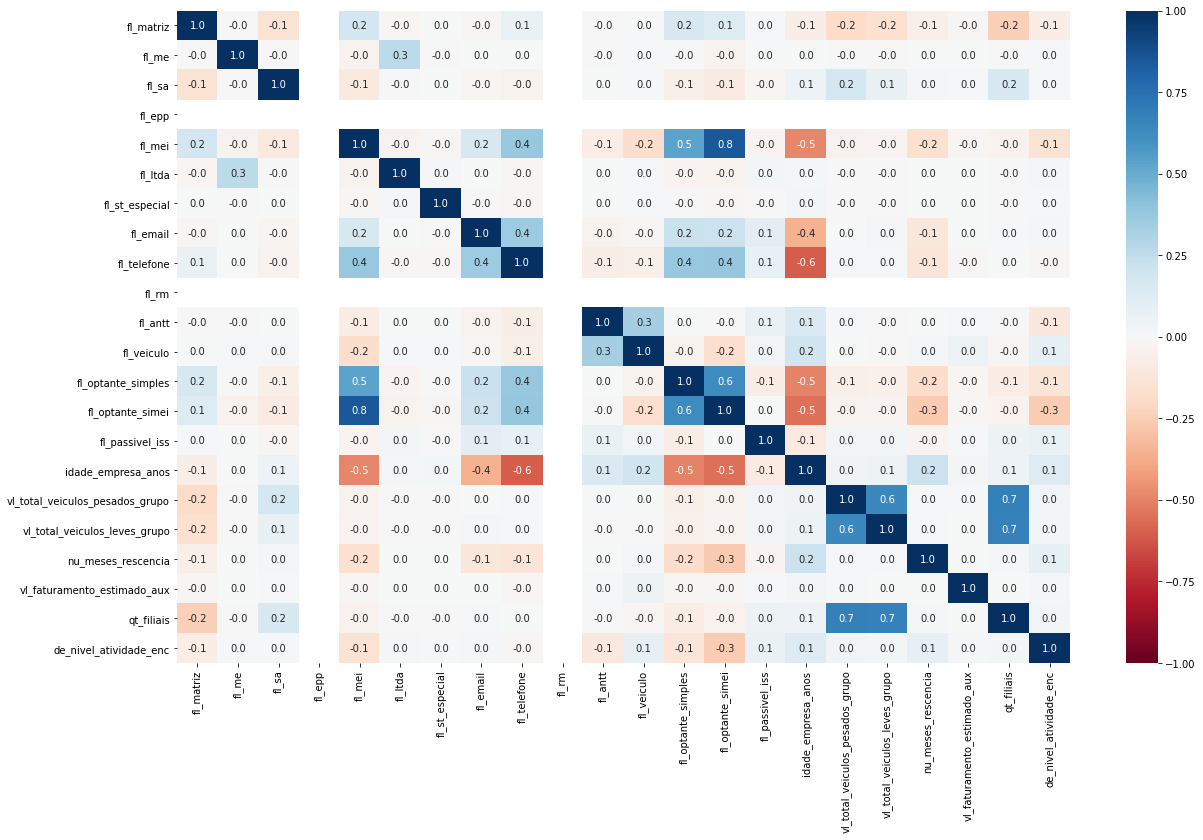

In [153]:
plt.figure(figsize = (20,12))

sns.heatmap(df_mark[bool_columns + num_columns + ord_columns].corr(), cmap = 'RdBu', annot = True, vmin=-1, vmax=1, fmt='.1f');

In [154]:
for i in range(0,len(bool_columns)):
  print("{}\n".format(df_mark[bool_columns].iloc[:,i].value_counts()))

1    440118
0     29417
Name: fl_matriz, dtype: int64

0    468284
1      1251
Name: fl_me, dtype: int64

0    461006
1      8529
Name: fl_sa, dtype: int64

0    469535
Name: fl_epp, dtype: int64

0    315823
1    153712
Name: fl_mei, dtype: int64

0    468285
1      1250
Name: fl_ltda, dtype: int64

0    469466
1        69
Name: fl_st_especial, dtype: int64

0    260224
1    209311
Name: fl_email, dtype: int64

1    341073
0    128462
Name: fl_telefone, dtype: int64

1    469535
Name: fl_rm, dtype: int64

0    464309
1      5226
Name: fl_antt, dtype: int64

0    436640
1     32895
Name: fl_veiculo, dtype: int64

1    287062
0    182473
Name: fl_optante_simples, dtype: int64

0    289693
1    179842
Name: fl_optante_simei, dtype: int64

1    270707
0    198828
Name: fl_passivel_iss, dtype: int64



Percebe-se que as colunas com pouca relevância são as booleanas que estão extramamente desbalanceadas. Portanto irei excluí-las também

In [155]:
drop = ['fl_epp', 'fl_rm', 'fl_st_especial', 'fl_me', 'fl_antt', 'fl_ltda']

df_mark.drop(drop, axis = 1, inplace = True)

### Preenchendo os Missing Values

In [156]:
pd.DataFrame({'nulls':df_mark.isnull().sum(),
              'types':df_mark.dtypes}).sort_values(by = 'nulls', ascending = False).iloc[0:6,:]

,nulls,types
nu_meses_rescencia,45915,float64
vl_faturamento_estimado_aux,27950,float64
de_saude_tributaria,15017,object
vl_total_veiculos_pesados_grupo,1927,float64
setor,1927,object
vl_total_veiculos_leves_grupo,1927,float64


Ao observar os dados das colunas, decidi preencher as colunas numéricas com a mediana e as colunas categóricas com o termo mais frequente 

- nu_meses_rescencia - média
- vl_faturamento_estimado_grupo_aux - mediana
- de_saude_tributaria - mediana
- vl_total_veiculos_pesados_grupo - 0, que é igual a moda
- setor - moda
- vl_total_veiculos_leves_grupo - 0, que é igual a moda

In [157]:
df_mark[obj_columns] = df_mark[obj_columns].fillna(df_mark[obj_columns].mode().iloc[0]) 
df_mark[num_columns] = df_mark[num_columns].fillna(df_mark[num_columns].median().iloc[0])

In [158]:
df_mark.isnull().sum().sum()

0

### Feature Engineering

In [159]:
def mul(x, y):
    """
    Função de multiplicação. É importante definir se quisermos deixar nosso pipeline pickeable.
    """
    return x*y

In [160]:
# irei dar maiores pesos à algumas colunas categóricas, portanto irei 
# criar uma lista com essas colunas

categorical_features = ['sg_uf', 'natureza_juridica_macro', 'setor','de_saude_tributaria']

# Essas são as features que quero dar maior peso
weight_categorical_features = ['de_ramo', 'fl_matriz', 'fl_sa']


numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p))])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

weight_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('mul', FunctionTransformer(mul, kw_args={'y': 2}))])

ordinal_transformer = Pipeline(steps=[
    ('he', ce.HelmertEncoder())])

gps_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


column_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, categorical_features),
        ('wcat', weight_categorical_transformer, weight_categorical_features),
        ('ord', ordinal_transformer, ord_columns),
        ('gps', gps_transformer, ['lat', 'lng'])
    ],
    remainder='passthrough'
)


preprocessor = Pipeline(steps=[
    ('col', column_transformer),
    ('pca', PCA(n_components=0.95))])

X = preprocessor.fit_transform(df_mark.drop(columns=['id']))

### Gerando Leads

In [161]:
nn_model = NearestNeighbors(n_neighbors=5, metric='cosine').fit(X)

In [162]:
def generate_lead(portfolio, n_leads = 5000):
  
  """
  Gera Leades para o Portfólio Indicado.

  parametro portfólio é o dataframe contendo os ID's do portfólio
  parametro n_leads é a quantidade de recomendações desejadas
  return ID's das empresas recomendadas

  """
  # buscamos as features do portfólio na base de mercado
  df = pd.merge(portfolio[['id']], df_mark, how = 'inner', on = 'id')
  # aplicamos o processamento das colunas
  X_pf = preprocessor.transform(df.drop(columns=['id']))

  # pega a distancia e os indices dos vizinhos mais próximos de cada portfolio
  distances, indices = nn_model.kneighbors(X_pf)
  distances = distances.flatten()
  indices = indices.flatten()

  # vamos remover os itens que existem dentro do portfolio
  mask = ~np.isin(indices, set(portfolio['id']))
  distances = distances[mask]
  indices = indices[mask]

  # agora vamos contar os duplicados e ordenaremos pela contagem e pela média das distâncias
  data = set(zip(distances, indices))
  recomendados = pd.DataFrame(data, columns=['distances', 'indices']) 
  top_indices = recomendados.groupby('indices').agg(count = ('indices', 'count'),
                               distances = ('distances', 'mean'))\
                               .sort_values(['count','distances'],
                                            ascending = [False, True]).index.values

  if n_leads is not None:
        top_indices = top_indices[:n_leads]    

  return  df_mark.loc[top_indices, 'id']                                           

### Testando os Leads

Vamos agora fazer o seguinte. Vamos dividir nossos portfólios em duas partes. Treinar em uma parte e testar na outra. Teoricamente, devemos ver semelhança entre os leads e o que já faz parte do portfólio.

In [163]:
def calculate_accuracy(ids_true, ids_pred):
    """
    Função para calcular o percentual de leads que já fazem parte do nosso portfólio
    """
    return len(set(ids_true) & set(ids_pred)) / len(set(ids_true))

In [164]:
def calculate_mc_accuracy(market, portfolio, sample_size, n_trials, random_state=None):
    """
    Função para calcular a média de acertos no aleatório usando simulação de monte-carlo.
    
    :param market: DataFrame contendo os dados do mercado
    :param portfolio: DataFrame contendo os dados do portfolio
    :param sample_size: número de sugestões que iremos avaliar por vez
    :param n_trials: número de execuções
    :param random_state: quando diferente de None, indica a semente randômica
    :returns: acurácia média
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    market_ids = market['id']
    ids_true = set(portfolio['id'])
    accuracies = np.zeros(n_trials)
    for k in range(n_trials):
        random_suggestion = market_ids.sample(n=sample_size)
        accuracies[k] = calculate_accuracy(ids_true, random_suggestion)
    return np.mean(accuracies)

#### Portfólio 1

In [165]:
pf1_train, pf1_valid = train_test_split(port1[['id']], test_size=0.3, random_state=0, shuffle=True)
print(pf1_train.shape)
print(pf1_valid.shape)

(388, 1)
(167, 1)


In [166]:
leads1 = generate_lead(pf1_train, n_leads=None)

In [167]:
acc = calculate_accuracy(pf1_valid['id'], leads1)
mc_acc = calculate_mc_accuracy(df_mark, pf1_valid, len(leads1), 1000, random_state=0)

print(f'O modelo indicou um total de {len(leads1)} sugestões. Destes, {acc*100:.2f}% estavam presentes na base de teste.')
print(f'Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de {mc_acc*100:.2f}%.')

O modelo indicou um total de 2002 sugestões. Destes, 1.20% estavam presentes na base de teste.
Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de 0.43%.


#### Portfólio 2

In [168]:
pf2_train, pf2_valid = train_test_split(port2[['id']], test_size=0.3, random_state=0, shuffle=True)
print(pf2_train.shape)
print(pf2_valid.shape)

(396, 1)
(170, 1)


In [169]:
leads2 = generate_lead(pf2_train, n_leads=None)

In [170]:
acc = calculate_accuracy(pf2_valid['id'], leads2)
mc_acc = calculate_mc_accuracy(df_mark, pf2_valid, len(leads2), 1000, random_state=0)

print(f'O modelo indicou um total de {len(leads2)} sugestões. Destes, {acc*100:.2f}% estavam presentes na base de teste.')
print(f'Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de {mc_acc*100:.2f}%.')

O modelo indicou um total de 1374 sugestões. Destes, 64.71% estavam presentes na base de teste.
Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de 0.30%.


#### Portfólio 3

In [171]:
pf3_train, pf3_valid = train_test_split(port3[['id']], test_size=0.3, random_state=0, shuffle=True)
print(pf3_train.shape)
print(pf3_valid.shape)

(185, 1)
(80, 1)


In [172]:
leads3 = generate_lead(pf3_train, n_leads=None)

In [173]:
acc = calculate_accuracy(pf3_valid['id'], leads3)
mc_acc = calculate_mc_accuracy(df_mark, pf3_valid, len(leads3), 1000, random_state=0)

print(f'O modelo indicou um total de {len(leads3)} sugestões. Destes, {acc*100:.2f}% estavam presentes na base de teste.')
print(f'Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de {mc_acc*100:.2f}%.')

O modelo indicou um total de 605 sugestões. Destes, 53.75% estavam presentes na base de teste.
Usando modelo aleatório de sugestões, a média de acertos na base de teste foi de 0.14%.


## Avaliando Similaridade

Agora avaliaremos a similiaridade entre as recomendações geradas e os portfólios

In [174]:
comparative_cols = ['id', 'sg_uf', 'de_ramo', 'setor', 'idade_emp_cat', 'de_faixa_faturamento_estimado', 
                    'nm_meso_regiao', 'nm_micro_regiao']

market = pd.read_csv('/content/drive/My Drive/estaticos_market.csv', usecols=comparative_cols)\
                    .merge(microregioes, on='nm_micro_regiao', how='left')

In [175]:
def get_market_info(ids, df_mark):
    """
    Une ID's com a base de mercado
    
    :param ids: ids que queremos juntar com a base de mercado
    :param market: base de mercado
    :returns: DataFrame com os dados unidos
    """
    result = pd.DataFrame(ids, columns=['id']).merge(df_mark, on='id', how='inner')
    return result

In [176]:
def comparative_barplot(df1, df2, cols, df_names=None, ax=None):
    """
    Plota gráfico de barras comparando uma mesma coluna entre 2 dataframes.
    
    :param df1: DataFrame de comparação 1
    :param df2: DataFrame de comparação 2
    :param df_names: nomes das bases, se quisermos configurar algo
    :param ax: eixo do matplotlib que iremos vincular
    """
    data1 = df1[cols].dropna().copy()
    data2 = df2[cols].dropna().copy()
    
    keys = []
    keys.append('base 1' if df_names is None else df_names[0])
    keys.append('base 2' if df_names is None else df_names[1])
    
    data1['base'] = keys[0]
    data2['base'] = keys[1]
    
    df = pd.concat([data1, data2], keys=keys)
    df_group = df.groupby(cols + ['base'])

    plot = df_group.size().unstack('base').plot(kind='bar', ax=ax)
    return plot

In [177]:
def gen_comparative(portfolio, leads, features, cols=3, title=''):
    """
    Apresenta gráficos comparando a base de portfólio com os leads indicados
    
    :param portfolio: dataframe com o portfolio
    :param leads: dataframe com os leads
    :param features: features que queremos comparar
    :param cols: número máximo de colunas da grade
    :param title: título da figura
    """
    rows = math.ceil(len(features) / cols)
    figwidth  = 5 * cols
    figheight = 8 * rows
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(figwidth, figheight))
    
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    ax = ax.ravel()
    
    for i, feature in enumerate(features):
        comparative_barplot(portfolio, leads, [feature], ['portfólio', 'leads'], ax=ax[i])
        
    fig.suptitle(title, size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.92)
    plt.show()

#### Portfólio 1

Agora vamos testar com o portfólio 1 inteiro. Vamos gerar uma lista de leads do mesmo tamanho que a do porfólio para facilitar a comparação.

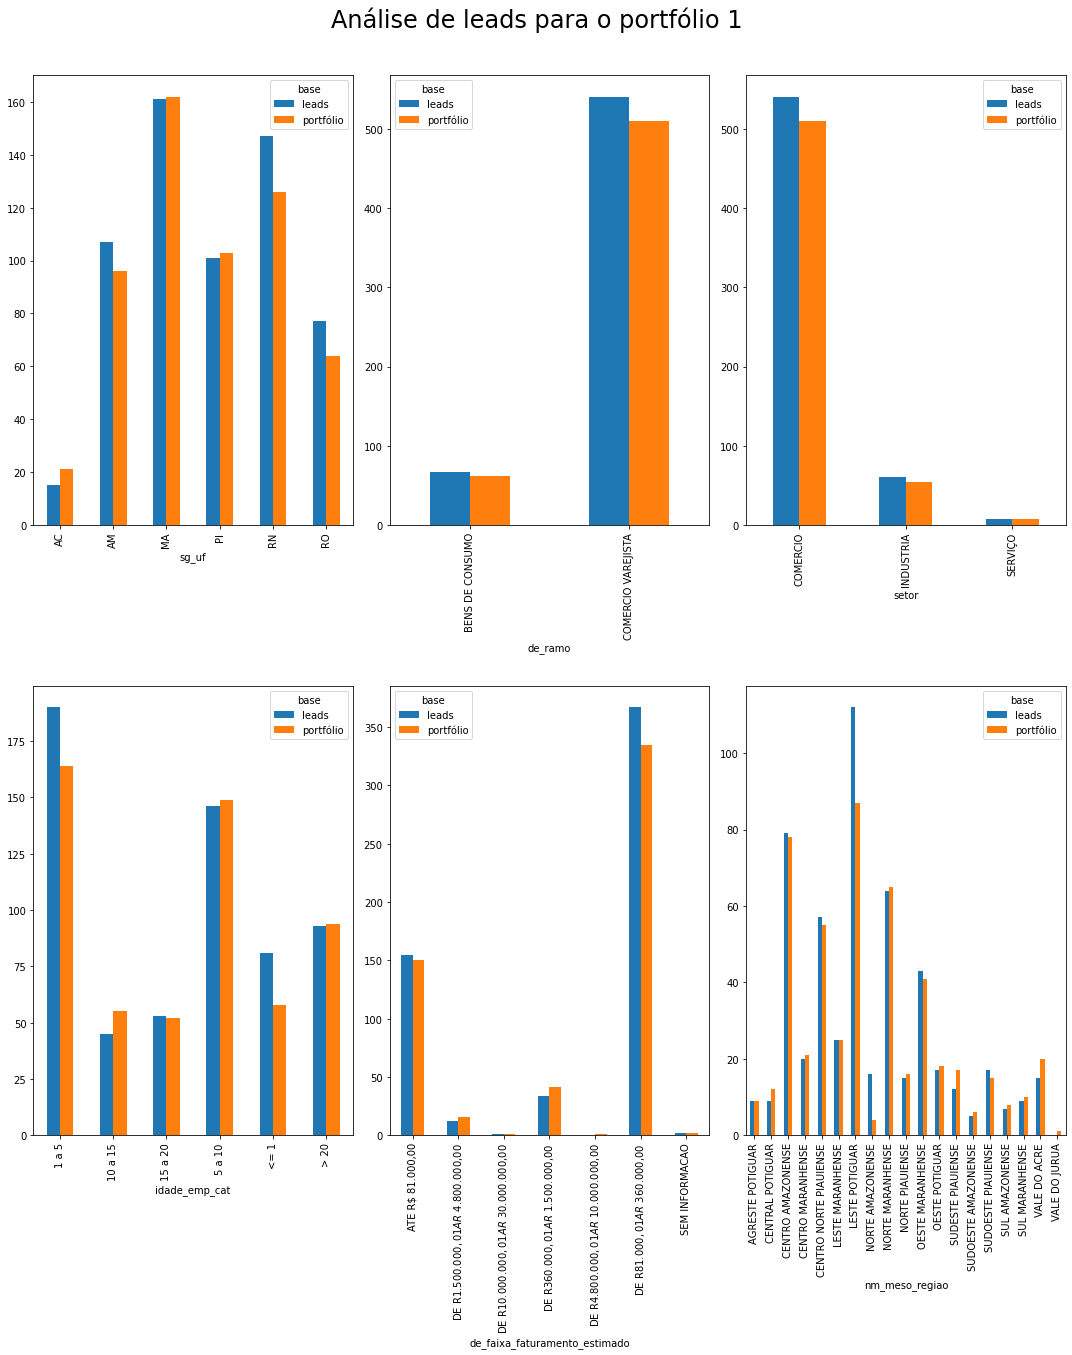

In [178]:
pf1 = pd.merge(port1[['id']], market, on='id', how='inner')
leads = generate_lead(pf1, n_leads=pf1.shape[0])
leads_df = get_market_info(leads, market)
gen_comparative(pf1, leads_df, comparative_cols[1:7], cols=3, title='Análise de leads para o portfólio 1')

Podemos observar que os leads estão muito próximos do que consta no portfólio. Inclusive na meso região, feature que nem usamos no nosso modelo. Parece que as features de latitude e longitude fizeram efeito aqui.

#### Portfólio 2

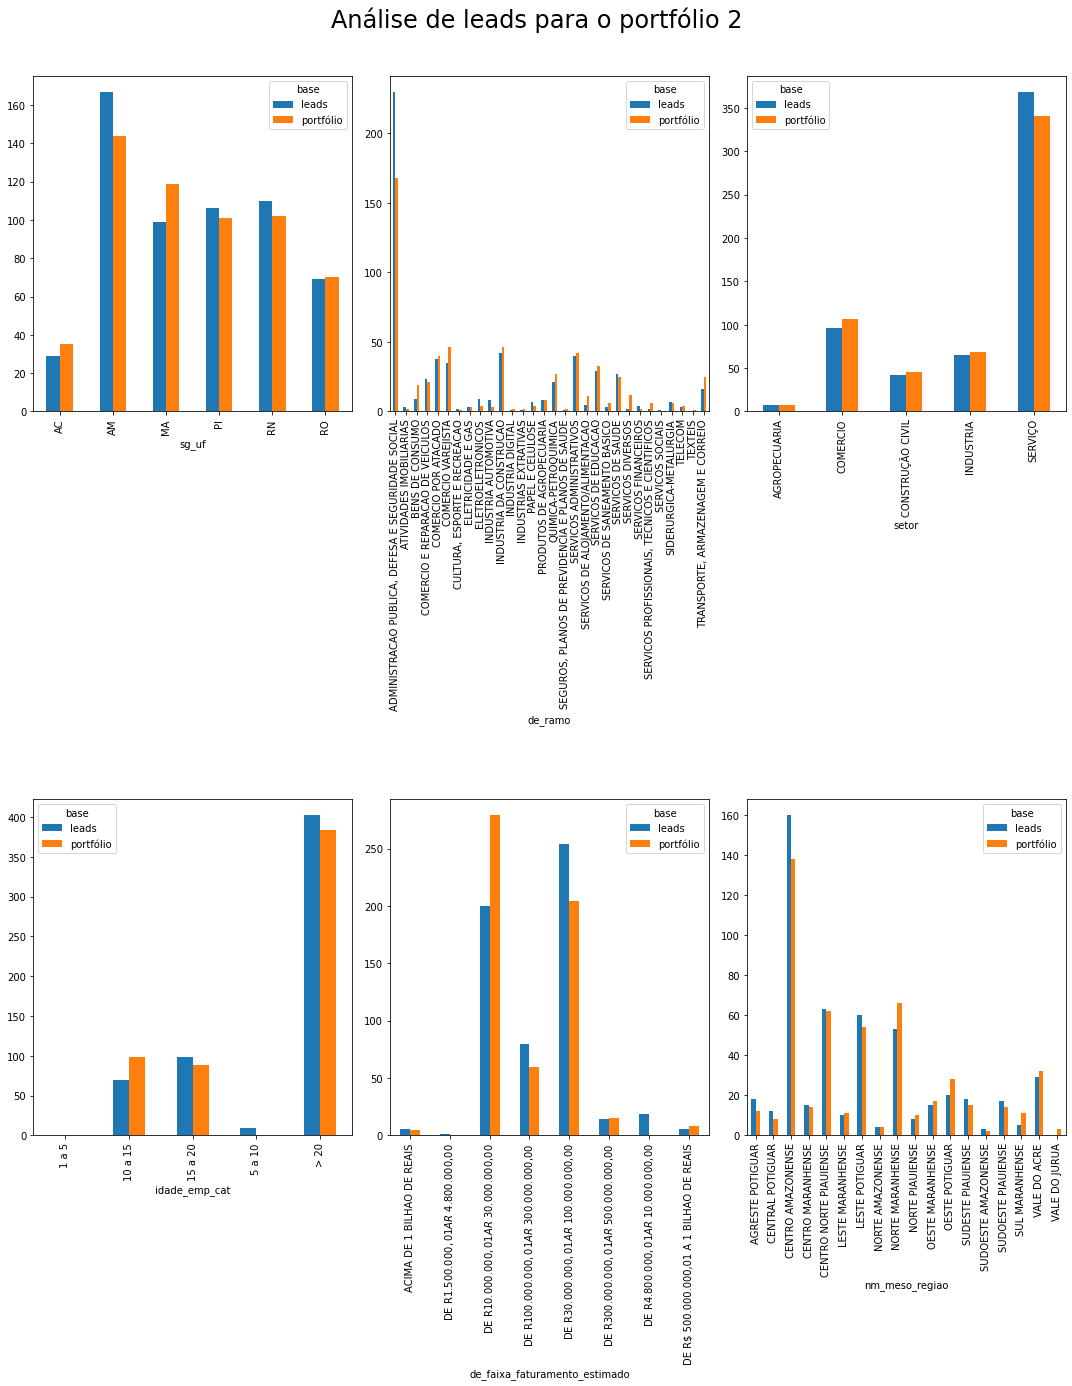

In [179]:
pf2 = pd.merge(port2[['id']], market, on='id', how='inner')
leads = generate_lead(pf2, n_leads=pf2.shape[0])
leads_df = get_market_info(leads, market)
gen_comparative(pf2, leads_df, comparative_cols[1:7], cols=3, title='Análise de leads para o portfólio 2')

Percebemos que as sugestões também são bem similares ao portfólio 2 

#### Portfólio 3

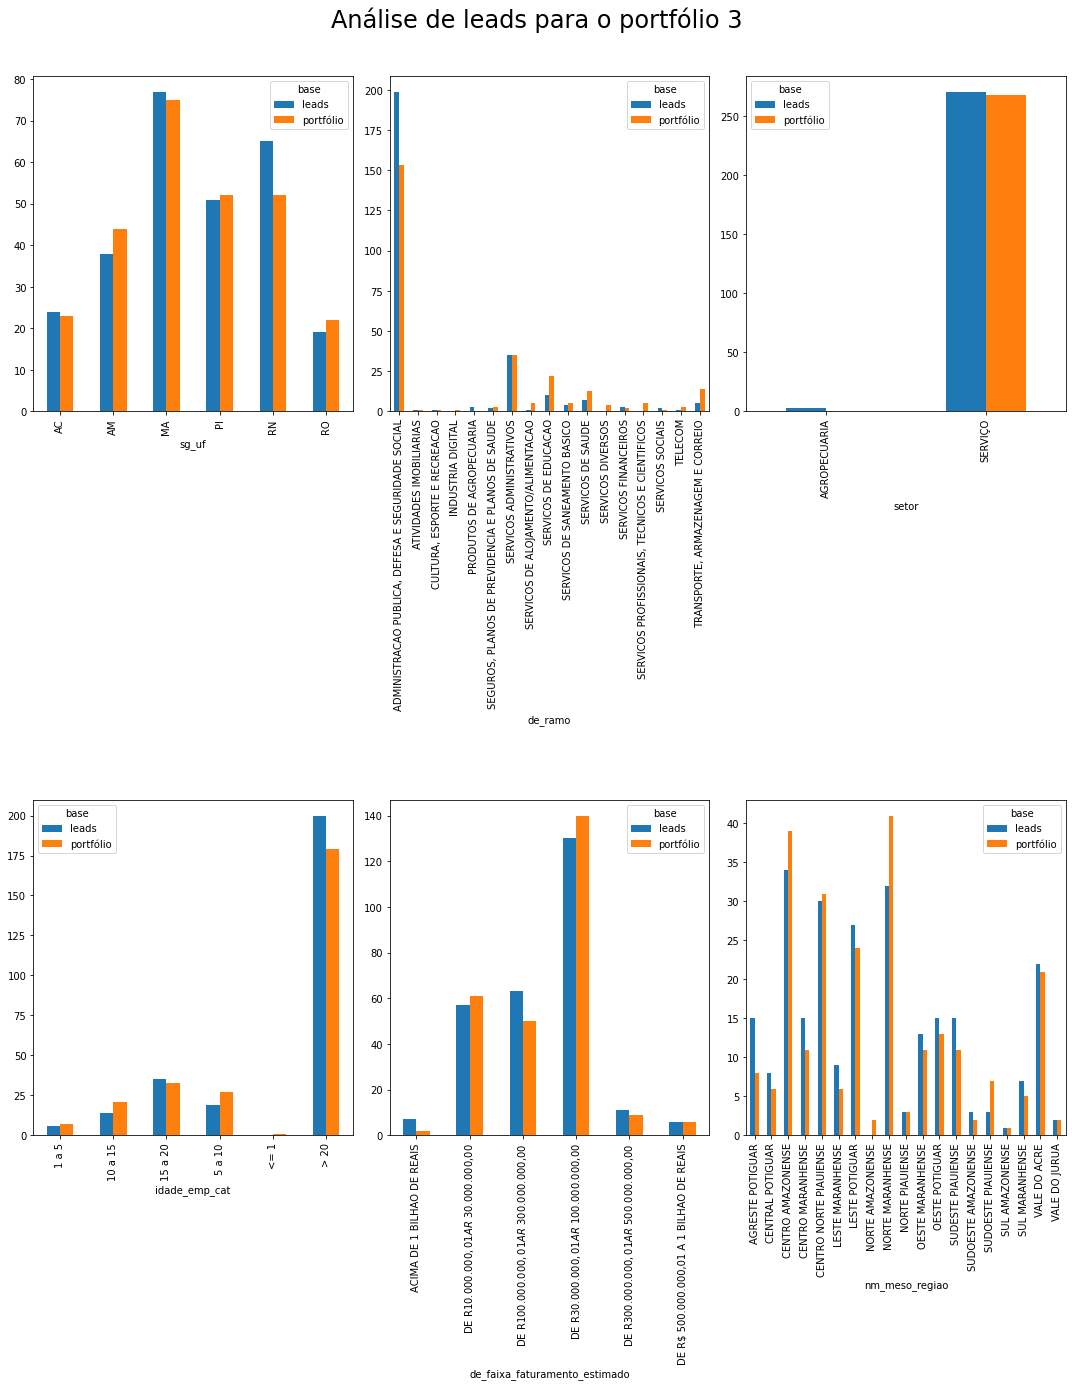

In [180]:
pf3 = pd.merge(port3[['id']], market, on='id', how='inner')
leads = generate_lead(pf3, n_leads=pf3.shape[0])
leads_df = get_market_info(leads, market)
gen_comparative(pf3, leads_df, comparative_cols[1:7], cols=3, title='Análise de leads para o portfólio 3')

### Conclusões:

A aceleração da Codenation foi sensacional e fechou com chave de ouro com esse projeto! Foi muto desafiador e pude aprender muito sobre como tratar grandes bases de dados, sobre clustering, data Engineering e diversas outras habilidades. Agradeço muito a [Codenation](https://www.codenation.dev/) pela oportunidade e pelo trabalho fantástico!!